This module:
    1. Calculate the data for actual hourly/daily data
    2. Resave the file in correct format
    3. Write functions to automate these processes 
        ***getDeltaSeries() => replaceCseries()
    4  Explore merging the pumped time with actual pumped time

In [1]:
import os, sys
import pandas as pd 
import numpy as np
import requests 
from datetime import datetime, date, time, timedelta
import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from mpl_finance import candlestick_ohlc
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.ticker as mticker
pd.set_option('display.max_columns', 999)
%load_ext autoreload
%matplotlib inline

In [2]:
print(os.getcwd())

/Users/hn/Documents/USC Others/ISI Research/PumpCoin/CrytoCompare/All_Pump_Analysis/Before_Announcement_Analysis


# PART 1: TRANSFORM DATA INTO TRUE TIME SERIES

## Test on the coin KRL
Pandas can handle elementwise subtraction just fine. No need to turn into numpy. 
**BUT**
We see that some variables increase monotomously, while others are actual count (number of followers).
==> Must investigate this!

In [4]:
krl = pd.read_pickle("../../Social_Data/Hourly/Hourly_AE_190978.pkl")
krl_cols = krl.columns
krl.shape

(16008, 36)

In [5]:
krl.head(2)

,time,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,date,date_utc
0,1520154000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,2018-03-04 01:00:00,2018-03-04 09:00:00+00:00
1,1520157600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,2018-03-04 02:00:00,2018-03-04 10:00:00+00:00


In [6]:
x = krl.iloc[:1].append(krl.iloc[:-1], ignore_index = True)
#Turn the first row into 0
x.iloc[:1] = 0
x = x.drop(['date','date_utc'],axis=1)
# x['time'] = 0

In [7]:
krl_final = krl.drop(['date','date_utc'],axis=1) - x
krl_final.head()

,time,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors
0,1.520154e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.527354e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.534554e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.541754e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.548954e+09,115.0,65.0,273.0,9600.0,27644.0,729.0,1996.0,2872.0,694.0,2756.0,269.0,36960.0,2539.0,122.0,960.0,0.0,24.0,0.0,1.0,6308.0,2266.0,0.06,1.51,0.12,2.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
krl_final.shape

(30015, 34)

In [59]:
check_cols = []
for col in krl_final.columns:
    if any(krl_final[col] < 0): 
        check_cols.append(col)

In [60]:
# krl[check_cols].iloc[-1:]
# col_inx = list(set(krl.columns.tolist( )) - set(check_cols))
# # col_inx/
# krl['fb_talking_about'].plot(figsize=(15,5))

In [61]:
def getSocialDelta(df: pd.DataFrame, delta: int, drop_cols: list = []):
    '''
    Given a dataframe with time series (OHLCV/Data), calculate the data points for each 
    t_x - t_delta. 
    Returns: a dataframe with the same shape as the original. 
    param df : Pandas dataframe with time series. 
    !!Must contain varibale time := UNIX timestamp for GMT zone as anchor 
    param delta: integer for the number of days/hours/secs to go back
    drop_cols: a list of columns names to exclude from consideration 
    '''
    if delta < 1: 
        print('Time delta must be an integer greater than 1')
        return None
    temp = df[['time'] + drop_cols]
    temp = temp.rename(columns = {'time':'time_temp'})
    #Append the first few rows of the original data as buffer
    x = df.iloc[:delta].append(df.iloc[:-delta], ignore_index=True)
    x = x.drop(drop_cols,axis= 1)
    #Turn the first row to all 0 
    x.iloc[:delta] = 0
    x['time'] = 0 

    f = df.drop(drop_cols,axis=1) - x 
    #Merge back the drop cols 
    final = pd.merge(left=f,left_on='time',right=temp,right_on='time_temp',how='left')
    final = final.drop('time_temp', axis=1)
    return final 

In [62]:
drop_cols = ['date','date_utc']
krl_d1 = getSocialDelta(krl,1,drop_cols)

In [63]:
krl_d1[-5:]

,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,time,date,date_utc
1996,0,0,0,0,5,0,0,0,0,0,0,5,0,0,10,0,0,13,3,0,-587,0.0,0.00,-0.01,-0.02,0,0,0,0,2,0,0,0,1569542400,2019-09-26 17:00:00,2019-09-27 00:00:00+00:00
1997,0,0,0,0,2,0,0,0,0,0,0,2,0,0,-11,0,-1,6,1,-1,79,0.0,-0.02,0.00,-0.01,0,0,0,0,0,0,0,0,1569628800,2019-09-27 17:00:00,2019-09-28 00:00:00+00:00
1998,0,0,0,0,2,0,0,0,0,0,0,2,0,0,-1,0,0,0,0,0,439,0.0,-0.02,0.00,-0.01,0,0,0,0,0,0,0,0,1569715200,2019-09-28 17:00:00,2019-09-29 00:00:00+00:00
1999,0,0,0,0,3,0,0,0,0,0,0,3,0,0,5,0,0,8,4,-1,-277,0.0,0.00,0.00,-0.01,0,0,0,3,2,3,0,0,1569801600,2019-09-29 17:00:00,2019-09-30 00:00:00+00:00
2000,0,0,0,0,6,0,0,0,0,0,0,6,0,0,-3,1,0,9,3,1,59,0.0,0.01,0.00,-0.01,1,1,1,-1,3,5,0,0,1569888000,2019-09-30 17:00:00,2019-10-01 00:00:00+00:00


In [64]:
krl[-5:]

,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,time,date,date_utc
1996,121,76,308,10810,30536,785,2103,3072,755,2836,300,40387,2718,78,25007,282,590,3439,3336,6353,1880,0.06,1.38,0.04,1.07,825,181,133,17,2476,6,309,51,1569542400,2019-09-26 17:00:00,2019-09-27 00:00:00+00:00
1997,121,76,308,10810,30538,785,2103,3072,755,2836,300,40389,2718,78,24996,282,589,3445,3337,6352,1959,0.06,1.36,0.04,1.06,825,181,133,17,2476,6,309,51,1569628800,2019-09-27 17:00:00,2019-09-28 00:00:00+00:00
1998,121,76,308,10810,30540,785,2103,3072,755,2836,300,40391,2718,78,24995,282,589,3445,3337,6352,2398,0.06,1.34,0.04,1.05,825,181,133,17,2476,6,309,51,1569715200,2019-09-28 17:00:00,2019-09-29 00:00:00+00:00
1999,121,76,308,10810,30543,785,2103,3072,755,2836,300,40394,2718,78,25000,282,589,3453,3341,6351,2121,0.06,1.34,0.04,1.04,825,181,133,20,2478,9,309,51,1569801600,2019-09-29 17:00:00,2019-09-30 00:00:00+00:00
2000,121,76,308,10810,30549,785,2103,3072,755,2836,300,40400,2718,78,24997,283,589,3462,3344,6352,2180,0.06,1.35,0.04,1.03,826,182,134,19,2481,14,309,51,1569888000,2019-09-30 17:00:00,2019-10-01 00:00:00+00:00


## Categorize Social Media Variables

In [65]:
code = ['code_repo_stars',
'code_repo_forks' ,
'code_repo_subscribers',
'code_repo_open_pull_issues',
'code_repo_closed_pull_issues',
'code_repo_open_issues' ,
'code_repo_closed_issues']

In [66]:
twitter = ['twitter_followers',
'twitter_following',
'twitter_lists',
'twitter_favorites']

In [67]:
reddit = ['reddit_subscribers',
'reddit_active_users',
'reddit_posts_per_hour',
'reddit_post_per_day',
'reddit_comments_per_hour',
'reddit_cooments_per_day'
]

In [68]:
fb = ['fb_likes','fb_talking_about']

In [69]:
market = [
'comments',
'posts',
'followers' ,
'points',
'overview_page_views',
'analysis_page_views',
'markets_page_views',
'charts_page_views',
'trades_page_views',
'forum_page_views',
'influence_page_views',
'total_page_views'
]

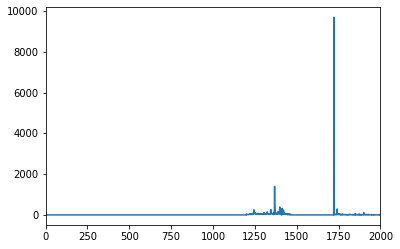

In [70]:
krl_d1['overview_page_views'].plot()

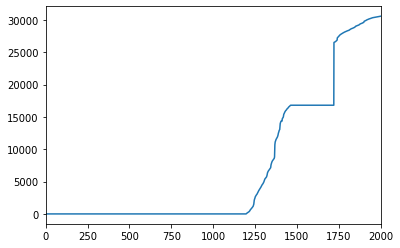

In [71]:
krl['overview_page_views'].plot()

## TURN CUMMULATIVE DATA INTO TIME SERIES DATA

In [72]:
c_vars = ['code_repo_forks','fb_likes']+market
# c_vars

In [73]:
def replaceCseries(df:pd.DataFrame, varlist:list=[]):
    '''
    Replace the variables which are cummulative series with their Time series counterpart 
    :param df: Dataframe to be processed, must contain variable Time as Unix series
    :param varlist: The list of varibles to be turned into time series
    Return the DF with the specified C-series turned into T-series
    '''
    orig_cols = df.columns.tolist()
    #Separate the "good" vs "bad" parts
    kept_list = list(set(orig_cols) - set(varlist))
    df_tba = df[kept_list]
    #Transform into time series
    x = getSocialDelta(df[['time']+varlist], 1)
    x = x.rename(columns = {'time':'time2'})
    f = pd.merge(left=df_tba, left_on='time',right=x,right_on='time2',how='left')
    f = f.drop('time2',axis=1)[orig_cols]
    return f 

In [96]:
krl_t = replaceCseries(krl,c_vars)

In [97]:
krl_t[1950:1955]

,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,time,date,date_utc
1950,0,0,0,0,14,1,0,0,0,0,1,16,3,212,24902,280,578,3026,3073,6354,762,0.06,1.43,0.07,1.67,816,0,139,16,2317,7,304,0,1565568000,2019-08-11 17:00:00,2019-08-12 00:00:00+00:00
1951,0,0,0,0,7,0,0,0,0,0,0,7,2,217,24888,280,578,3029,3082,6355,656,0.06,1.43,0.07,1.64,818,0,139,15,2322,7,304,0,1565654400,2019-08-12 17:00:00,2019-08-13 00:00:00+00:00
1952,0,0,0,0,10,0,0,0,1,0,0,11,1,205,24880,280,578,3033,3087,6355,660,0.06,1.43,0.07,1.63,818,0,139,20,2326,7,304,0,1565740800,2019-08-13 17:00:00,2019-08-14 00:00:00+00:00
1953,0,0,0,0,5,0,0,0,0,0,0,5,-1,193,24877,280,578,3038,3092,6354,758,0.06,1.39,0.07,1.60,818,0,139,20,2329,7,304,0,1565827200,2019-08-14 17:00:00,2019-08-15 00:00:00+00:00
1954,0,0,0,0,2,0,0,0,0,0,0,2,-1,182,24876,280,581,3041,3095,6353,787,0.06,1.37,0.07,1.60,818,0,139,19,2333,7,304,0,1565913600,2019-08-15 17:00:00,2019-08-16 00:00:00+00:00


In [76]:
krl[1950:1955]

,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,time,date,date_utc
1950,121,76,305,10735,30300,778,2099,3067,752,2831,293,40120,2692,212,24902,280,578,3026,3073,6354,762,0.06,1.43,0.07,1.67,816,174,139,16,2317,7,304,0,1565568000,2019-08-11 17:00:00,2019-08-12 00:00:00+00:00
1951,121,76,305,10735,30307,778,2099,3067,752,2831,293,40127,2694,217,24888,280,578,3029,3082,6355,656,0.06,1.43,0.07,1.64,818,174,139,15,2322,7,304,0,1565654400,2019-08-12 17:00:00,2019-08-13 00:00:00+00:00
1952,121,76,305,10735,30317,778,2099,3067,753,2831,293,40138,2695,205,24880,280,578,3033,3087,6355,660,0.06,1.43,0.07,1.63,818,174,139,20,2326,7,304,0,1565740800,2019-08-13 17:00:00,2019-08-14 00:00:00+00:00
1953,121,76,305,10735,30322,778,2099,3067,753,2831,293,40143,2694,193,24877,280,578,3038,3092,6354,758,0.06,1.39,0.07,1.60,818,174,139,20,2329,7,304,0,1565827200,2019-08-14 17:00:00,2019-08-15 00:00:00+00:00
1954,121,76,305,10735,30324,778,2099,3067,753,2831,293,40145,2693,182,24876,280,581,3041,3095,6353,787,0.06,1.37,0.07,1.60,818,174,139,19,2333,7,304,0,1565913600,2019-08-15 17:00:00,2019-08-16 00:00:00+00:00


**Now we can apply getSocialData on krl_t because every variable is a proper time series itself**

Write wrapper function to: 
    1. Transform every variable into time series
    2. Append the delta variables for t=1,2,3,...,15

In [77]:
def appendDelta(base:pd.DataFrame, delta: int=1, c_vars = []):
    '''
    Process the base df and append the variables that denote the difference in values
    for t up to [delta] days. 
    :param base: pandas Dataframe that contains mixed series
    :param delta: The number of days to go back in time 
    :param c_vars: List of Cummulative Variables
    '''
    if delta < 1: 
        print('Time delta must be an integer greater than 1')
        return None
    #1. Covert C series into T series
    base_t = replaceCseries(base, c_vars)
    src = base_t.copy()
    #2. Create the base table
    for t in range(1,delta+1):
        drop_cols = ['date','date_utc']
        d = getSocialDelta(src,t,drop_cols)
        d.drop(drop_cols, axis=1, inplace=True)
        #2. Append the columns
        base_t = pd.merge(left=base_t,left_on='time',right=d,right_on='time',how='left',suffixes=('','_d'+str(t)))
    return base_t

In [78]:
x = appendDelta(krl,5 ,c_vars)
x.shape
x.head()

,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,time,date,date_utc,comments_d1,posts_d1,followers_d1,points_d1,overview_page_views_d1,analysis_page_views_d1,markets_page_views_d1,charts_page_views_d1,trades_page_views_d1,forum_page_views_d1,influence_page_views_d1,total_page_views_d1,fb_likes_d1,fb_talking_about_d1,twitter_followers_d1,twitter_following_d1,twitter_lists_d1,twitter_favourites_d1,twitter_statuses_d1,reddit_subscribers_d1,reddit_active_users_d1,reddit_posts_per_hour_d1,reddit_posts_per_day_d1,reddit_comments_per_hour_d1,reddit_comments_per_day_d1,code_repo_stars_d1,code_repo_forks_d1,code_repo_subscribers_d1,code_repo_open_pull_issues_d1,code_repo_closed_pull_issues_d1,code_repo_open_issues_d1,code_repo_closed_issues_d1,code_repo_contributors_d1,comments_d2,posts_d2,followers_d2,points_d2,overview_page_views_d2,analysis_page_views_d2,markets_page_views_d2,charts_page_views_d2,trades_page_views_d2,forum_page_views_d2,influence_page_views_d2,total_page_views_d2,fb_likes_d2,fb_talking_about_d2,twitter_followers_d2,twitter_following_d2,twitter_lists_d2,twitter_favourites_d2,twitter_statuses_d2,reddit_subscribers_d2,reddit_active_users_d2,reddit_posts_per_hour_d2,reddit_posts_per_day_d2,reddit_comments_per_hour_d2,reddit_comments_per_day_d2,code_repo_stars_d2,code_repo_forks_d2,code_repo_subscribers_d2,code_repo_open_pull_issues_d2,code_repo_closed_pull_issues_d2,code_repo_open_issues_d2,code_repo_closed_issues_d2,code_repo_contributors_d2,comments_d3,posts_d3,followers_d3,points_d3,overview_page_views_d3,analysis_page_views_d3,markets_page_views_d3,charts_page_views_d3,trades_page_views_d3,forum_page_views_d3,influence_page_views_d3,total_page_views_d3,fb_likes_d3,fb_talking_about_d3,twitter_followers_d3,twitter_following_d3,twitter_lists_d3,twitter_favourites_d3,twitter_statuses_d3,reddit_subscribers_d3,reddit_active_users_d3,reddit_posts_per_hour_d3,reddit_posts_per_day_d3,reddit_comments_per_hour_d3,reddit_comments_per_day_d3,code_repo_stars_d3,code_repo_forks_d3,code_repo_subscribers_d3,code_repo_open_pull_issues_d3,code_repo_closed_pull_issues_d3,code_repo_open_issues_d3,code_repo_closed_issues_d3,code_repo_contributors_d3,comments_d4,posts_d4,followers_d4,points_d4,overview_page_views_d4,analysis_page_views_d4,markets_page_views_d4,charts_page_views_d4,trades_page_views_d4,forum_page_views_d4,influence_page_views_d4,total_page_views_d4,fb_likes_d4,fb_talking_about_d4,twitter_followers_d4,twitter_following_d4,twitter_lists_d4,twitter_favourites_d4,twitter_statuses_d4,reddit_subscribers_d4,reddit_active_users_d4,reddit_posts_per_hour_d4,reddit_posts_per_day_d4,reddit_comments_per_hour_d4,reddit_comments_per_day_d4,code_repo_stars_d4,code_repo_forks_d4,code_repo_subscribers_d4,code_repo_open_pull_issues_d4,code_repo_closed_pull_issues_d4,code_repo_open_issues_d4,code_repo_closed_issues_d4,code_repo_contributors_d4,comments_d5,posts_d5,followers_d5,points_d5,overview_page_views_d5,analysis_page_views_d5,markets_page_views_d5,charts_page_views_d5,trades_page_views_d5,forum_page_views_d5,influence_page_views_d5,total_page_views_d5,fb_likes_d5,fb_talking_about_d5,twitter_followers_d5,twitter_following_d5,twitter_lists_d5,twitter_favourites_d5,twitter_statuses_d5,reddit_subscribers_d5,reddit_active_users_d5,reddit_posts_per_hour_d5,reddit_posts_per_day_d5,reddit_comments_per_hour_d5,reddit_comments_per_day_d5,code_repo_stars_d5,code_repo_forks_d5,code_repo_subscribers_d5,c

After verifying that that the data comes out with the correct shape, mass implement and save the prossed file 
with the **prefix** processed_

In [79]:
print(x.filter(regex='d4').columns.shape)

(33,)


In [80]:
#The number of columns seems correct!!
36 + 5*33

201

# PART 2. NORMALIZE DATA INDEPENDENTLY IN EACH DATA SET

In [81]:
from sklearn.model_selection import train_test_split as tsplit
from sklearn.preprocessing import MinMaxScaler

p = pd.read_pickle("../pump_data_with_social.pkl")[['timestamp','pumptime_edited']]
p.sort_values('timestamp', inplace=True)

In [82]:
p.drop_duplicates(inplace=True)
p.reset_index(drop=True, inplace=True)
p.iloc[300:305]

,timestamp,pumptime_edited
300,1559314775,2019-05-31 14:59:35+00:00
301,1559406986,2019-06-01 16:36:26+00:00
302,1559483796,2019-06-02 13:56:36+00:00
303,1559491209,2019-06-02 16:00:09+00:00
304,1559509235,2019-06-02 21:00:35+00:00


We will use the date **May 31st at 12:00 AM** (beginning of day) as the cut off date
Timestamp: 1559260800

### Test on a single coin first

In [83]:
# ae = pd.read_pickle("../../Social_Data/Daily/Processed_Data/Daily_AE_190978_d14.pkl")
# ae = ae.reset_index(drop=True)

In [84]:
# ae_train = ae.loc[ae.time <= 1559260800]
# ae_test  = ae.loc[ae.time > 1559260800]
# print("Train set shape: {}, Test set shape: {}".format(ae_train.shape, ae_test.shape))
# ae.columns
# ae.head(2)

In [85]:
# features = ['comments', 'posts', 'followers', 'points', 'overview_page_views',
#        'analysis_page_views', 'markets_page_views', 'charts_page_views',
#        'trades_page_views', 'forum_page_views', 'influence_page_views',
#        'total_page_views', 'fb_likes', 'fb_talking_about', 'twitter_followers',
#        'twitter_following', 'twitter_lists', 'twitter_favourites',
#        'twitter_statuses', 'reddit_subscribers', 'reddit_active_users',
#        'reddit_posts_per_hour', 'reddit_posts_per_day',
#        'reddit_comments_per_hour', 'reddit_comments_per_day',
#        'code_repo_stars', 'code_repo_forks', 'code_repo_subscribers',
#        'code_repo_open_pull_issues', 'code_repo_closed_pull_issues',
#        'code_repo_open_issues', 'code_repo_closed_issues',
#        'code_repo_contributors']
# not_features = list(set(ae.columns) - set(features))
# print("There are {} features, and {} leftover variables".format(len(features),len(not_features)))

In [86]:
# mmscaler = MinMaxScaler()
# mmscaler.fit(ae_train[features])
# print(mmscaler.min_)

In [87]:
# train1 = mmscaler.transform(ae_train[features])
# train2 = ae_train[not_features].values
# ae_train_t = pd.DataFrame(np.concatenate((train1,train2),axis=1), columns=features+not_features)

In [88]:
# test1 = mmscaler.transform(ae_test[features])
# test2 = ae_test[not_features].values
# ae_test_t = pd.DataFrame(np.concatenate((test1,test2),axis=1), columns=features+not_features)

In [89]:
# ae_test_t.head(3)

In [90]:
# ae_test.head(3)

In [91]:
def minmaxNorm(df: pd.DataFrame, cutoff :int, features:list):
    '''
    Split the input dataframe between training and testing at the cutoff and and apply 
    Min-max Normalization from Scikit-learn
    :param df: the input Dataframe with variable timestamp as integer
    :cutoff df: the timestamp to split between Training and testing
                If cutoff = 0, then we normalize the entire dataset
    :param features: a list of variables name to be transformed
    '''
    p = df.copy().sort_values('time')
    p = p.reset_index(drop=True)
    not_features = list(set(p.columns) - set(features))
    mmscaler = MinMaxScaler()
    if cutoff > 0:
      
        p_train = p.loc[p.time <= cutoff]
        p_test  = p.loc[p.time > cutoff]
        print("Train set shape: {}, Test set shape: {}".format(p_train.shape, p_test.shape))

        mmscaler.fit(p_train[features])

        train1 = mmscaler.transform(p_train[features])
        train2 = p_train[not_features].values
        p_train_t = pd.DataFrame(np.concatenate((train1,train2),axis=1), columns=features+not_features)
        p_train_t['train'] = 1

        test1 = mmscaler.transform(p_test[features])
        test2 = p_test[not_features].values
        p_test_t = pd.DataFrame(np.concatenate((test1,test2),axis=1), columns=features+not_features)
        p_test_t['train'] = 0

        #Stack them on top of each other; 
        r = p_train_t.append(p_test_t,ignore_index=True )
        r = r.reset_index(drop=True)
        return r 
    else: 
        print("Data shape: {}".format(p.shape))
        mmscaler.fit(p[features])
        ps = mmscaler.transform(p[features])
        ps2 = p[not_features].values
        r = pd.DataFrame(np.concatenate((ps,ps2),axis=1), columns=features+not_features)
        return r 

In [92]:
ae = pd.read_pickle("../../Social_Data/Daily/Daily_AE_190978.pkl")
ae = ae.reset_index(drop=True)

In [93]:
# minmaxNorm(ae, 0, features)

# Part 3: BATCH PROCESS

In [94]:
#These are the features to turn into True time series
features = ['comments', 'posts', 'followers', 'points', 'overview_page_views',
       'analysis_page_views', 'markets_page_views', 'charts_page_views',
       'trades_page_views', 'forum_page_views', 'influence_page_views',
       'total_page_views', 'fb_likes', 'fb_talking_about', 'twitter_followers',
       'twitter_following', 'twitter_lists', 'twitter_favourites',
       'twitter_statuses', 'reddit_subscribers', 'reddit_active_users',
       'reddit_posts_per_hour', 'reddit_posts_per_day',
       'reddit_comments_per_hour', 'reddit_comments_per_day',
       'code_repo_stars', 'code_repo_forks', 'code_repo_subscribers',
       'code_repo_open_pull_issues', 'code_repo_closed_pull_issues',
       'code_repo_open_issues', 'code_repo_closed_issues',
       'code_repo_contributors']

### Process DAILY data

In [111]:
dir_preffix = '../../Social_Data/Daily'
c_vars = ['code_repo_forks','fb_likes']+market
social_error = []
for filename in os.listdir(dir_preffix):
    if 'pkl' in filename:
        #Memorize filename for appending later 
        _,coin_name,coin_id  =  filename.split('_')
        coin_id = coin_id[:-4]
        f = pd.read_pickle(dir_preffix+'/'+filename)
        #We go back 31 days before
        new_filename = filename.replace('.pkl','') + '_Time.pkl'
        print("Processing ", new_filename, "with shape",f.shape)
        try: 
            #Replace the data as time series
            f_t = replaceCseries(f,c_vars)
            f_t['coin_name'] = coin_name
            f_t['coin_id'] = coin_id
            f_t.to_pickle(dir_preffix + '/Processed Data/Time Series/'+new_filename)
            #Normalize the time series
            n = minmaxNorm(f_t,1559260800,features)
            n.to_pickle(dir_preffix + '/Processed Data/Normalized Series/Minmax_'+new_filename)
        except :
            e = sys.exc_info()[0]
            social_error.append(filename)
            print(e)
            continue

Processing  Daily_GBG_890044_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_BSV_926591_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_WINGS_25946_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_BAT_107672_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_REN_788239_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_SEL_41967_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_LEND_418778_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_WIT_925264_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_SIG_867303_Time.pkl with shape (2001, 36)
Train set shape: (1

Processing  Daily_CVC_139467_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_CTXC_856139_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_KRL_877048_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_TKN_71077_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_BNT_22327_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_SYS_4618_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_NXS_6103_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_ZIL_716725_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_BXT_28208_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38

Processing  Daily_WAN_240142_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_NEBL_222085_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_DCR_16713_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_PINK_5374_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_REQ_335059_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_RCN_307219_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_DLT_220204_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_KTK_5311_Time.pkl with shape (2001, 36)
Train set shape: (1878, 38), Test set shape: (123, 38)
Processing  Daily_XZC_30022_Time.pkl with shape (2001, 36)
Train set shape: (1878, 

In [112]:
social_error

['daily_social_error.pkl']

### Process HOURLY Data

In [113]:
dir_preffix = '../../Social_Data/Hourly'
c_vars = ['code_repo_forks','fb_likes']+market
social_error = []
for filename in os.listdir(dir_preffix):
    if 'pkl' in filename:
        #Memorize filename for appending later 
        _,coin_name,coin_id  =  filename.split('_')
        coin_id = coin_id[:-4]
        f = pd.read_pickle(dir_preffix+'/'+filename)
        #We go back 31 days before
        new_filename = filename.replace('.pkl','') + '_Time.pkl'
        print(new_filename)
        try: 
            #Replace the data as time series
            f_t = replaceCseries(f,c_vars)
            f_t['coin_name'] = coin_name
            f_t['coin_id'] = coin_id
            f_t.to_pickle(dir_preffix + '/Processed Data/Time Series/'+new_filename)
            #Normalize the time series
            n = minmaxNorm(f_t,1559260800,features)
            n.to_pickle(dir_preffix + '/Processed Data/Normalized Series/Minmax_'+new_filename)
        except: 
            social_error.append(filename)
            continue

Hourly_MTH_208914_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_MANA_199148_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_XPTX_385933_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_SEL_41967_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_VIB_198710_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_NAV_4571_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_CRPT_710597_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_PTOY_129035_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_BRX_299415_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_NPXS_731516_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_SSH_885637_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_POA_793845_Time.pkl
Train set shape: (11084, 38), Test set shape: (

Hourly_TUSD_844139_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_UKG_371005_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_NPC_34491_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_FTC_4524_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_CND_338070_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_GRC_5309_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_AST_337162_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_POWR_339617_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_SUB_221463_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_HDG_237407_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_FRN_20991_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 38)
Hourly_CHP_819737_Time.pkl
Train set shape: (11084, 38), Test set shape: (2959, 

In [115]:
social_error

['hourly_social_error.pkl']

# Test a processed file

### DAILY

In [121]:
t = pd.read_pickle("../../Social_Data/Daily/Processed Data/Time Series/Daily_TRX_310829_Time.pkl")
# ae[-5:]

In [123]:
t_n = pd.read_pickle("../../Social_Data/Daily/Processed Data/Normalized Series/Minmax_Daily_TRX_310829_Time.pkl")
# ae_n[-5:]

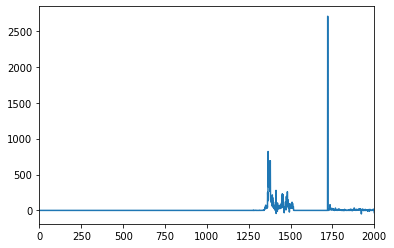

In [124]:
t.comments.plot()

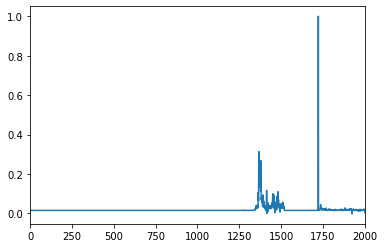

In [125]:
t_n.comments.plot()

So there are a couple of XX_closed_issues variables that are quite suscpect...

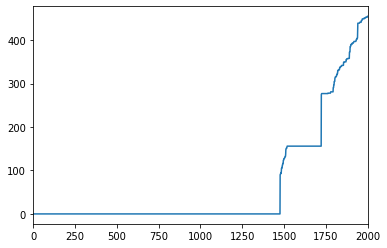

In [126]:
t.code_repo_closed_issues.plot()

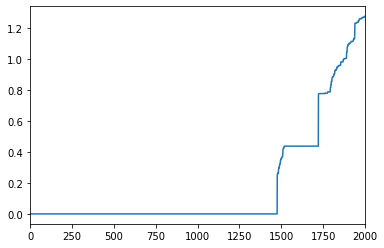

In [127]:
t_n.code_repo_closed_issues.plot()

### HOURLY

In [133]:
t = pd.read_pickle("../../Social_Data/Hourly/Processed Data/Time Series/Hourly_TRX_310829_Time.pkl")

In [132]:
t_n = pd.read_pickle("../../Social_Data/Hourly/Processed Data/Normalized Series/Minmax_Hourly_TRX_310829_Time.pkl")

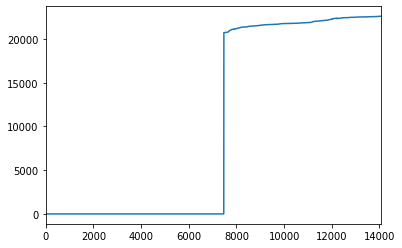

In [134]:
t.comments.plot()

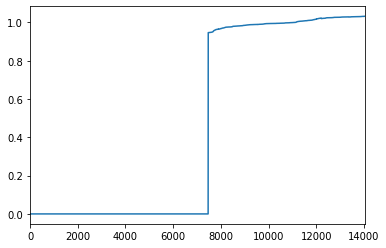

In [135]:
t_n.comments.plot()